In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses, activations, models, metrics, optimizers, callbacks, datasets, backend

# Building an Image Classifier

In [2]:
(X_train_full, y_train_full), (X_test, y_test) =  datasets.mnist.load_data()

In [3]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [4]:
K = backend

class ExponentialLearningRate(callbacks.Callback):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        # get current LR
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.rates.append(lr)
        self.losses.append(logs.get("loss"))
        # compute new LR
        new_lr = lr * self.factor
        # set new LR (works with modern Keras)
        self.model.optimizer.learning_rate.assign(new_lr)

class SaveModelAsJSON(callbacks.Callback):

    def __init__(self, path):
        super().__init__()
        self.path = path
        self.name = "model_architecture.json"
        self.filepath = os.path.join(self.path, self.name)

  def on_train_end(self, logs=None):
        json_config = self.model.to_json()
        with open(self.filepath, "w") as json_file:
            json_file.write(json_config)

In [5]:
early_stop = callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

expon_lr = ExponentialLearningRate(factor=1.005)

In [6]:
model = models.Sequential([
    layers.InputLayer(shape=(28, 28)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(loss=losses.sparse_categorical_crossentropy,
              optimizer=optimizers.Adam(learning_rate=0.02),
              metrics=[metrics.sparse_categorical_accuracy])

history = model.fit(X_train,
                    y_train,
                    epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[
                        early_stop,
                        expon_lr
                    ],
                    verbose=2)

1719/1719 - 8s - 5ms/step - loss: 10.8537 - sparse_categorical_accuracy: 0.2032 - val_loss: 98.1289 - val_sparse_categorical_accuracy: 0.1100


Text(0, 0.5, 'Loss')

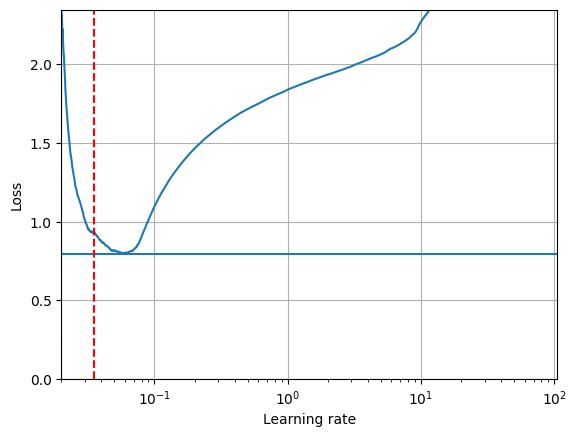

In [7]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis((min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]))
plt.axvline(x=0.035, color='r', linestyle='--')
plt.axvline(x=0.02, color='g', linestyle='--')
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [8]:
run_index = 1  # increment this at every run
run_logdir = os.path.join(os.curdir, "mnist_logs", "run_{:03d}".format(run_index))

tensorboard_cb = callbacks.TensorBoard(run_logdir)
model_schema_cb = SaveModelAsJSON(run_logdir)

checkpoint_cb = callbacks.ModelCheckpoint(os.path.join(run_logdir, "model.keras"),
                                          save_best_only=True)

In [9]:
model = models.Sequential([
    layers.InputLayer(shape=(28, 28)),
    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate=0.02),
              metrics=["accuracy"])

history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[
                        checkpoint_cb,
                        early_stop,
                        tensorboard_cb,
                        model_schema_cb
                        # expon_lr
                    ],
                    verbose=2)

Epoch 1/100
1719/1719 - 6s - 4ms/step - accuracy: 0.8673 - loss: 0.4471 - val_accuracy: 0.9106 - val_loss: 0.3342
Epoch 2/100
1719/1719 - 4s - 2ms/step - accuracy: 0.9007 - loss: 0.3548 - val_accuracy: 0.9168 - val_loss: 0.3071
Epoch 3/100
1719/1719 - 4s - 3ms/step - accuracy: 0.9100 - loss: 0.3337 - val_accuracy: 0.9158 - val_loss: 0.3340
Epoch 4/100
1719/1719 - 4s - 3ms/step - accuracy: 0.9175 - loss: 0.3199 - val_accuracy: 0.9218 - val_loss: 0.3016
Epoch 5/100
1719/1719 - 4s - 2ms/step - accuracy: 0.9202 - loss: 0.3098 - val_accuracy: 0.9168 - val_loss: 0.3420
Epoch 6/100
1719/1719 - 4s - 2ms/step - accuracy: 0.9198 - loss: 0.3110 - val_accuracy: 0.9116 - val_loss: 0.3253
Epoch 7/100
1719/1719 - 4s - 3ms/step - accuracy: 0.9222 - loss: 0.3008 - val_accuracy: 0.9304 - val_loss: 0.2877
Epoch 8/100
1719/1719 - 5s - 3ms/step - accuracy: 0.9242 - loss: 0.2944 - val_accuracy: 0.9288 - val_loss: 0.2930
Epoch 9/100
1719/1719 - 5s - 3ms/step - accuracy: 0.9259 - loss: 0.2888 - val_accuracy: 

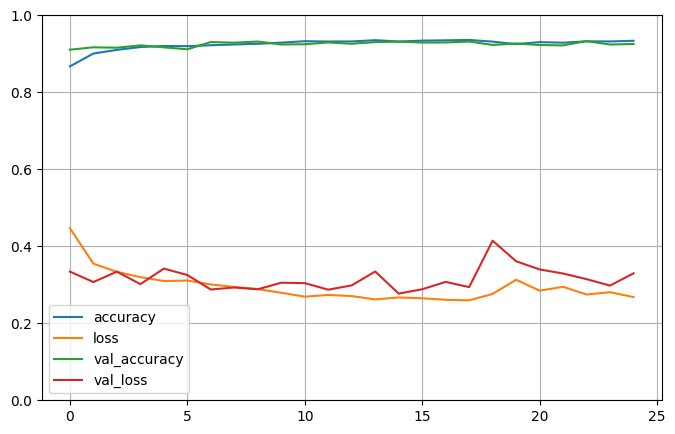

In [10]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir=./logs --port=600

In [ ]:
model = models.load_model("my_mnist_model.keras")

## Fashion MNIST Dataset

In [ ]:
fashion_mnist = datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) =  datasets.fashion_mnist.load_data()

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [ ]:
run_index = 2  # increment this at every run

run_logdir = os.path.join(os.curdir, "my_fashion_mnist_logs", "run_{:03d}".format(run_index))

tensorboard_cb = callbacks.TensorBoard(run_logdir)

In [ ]:
early_stop = callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True
)
checkpoint_cb = callbacks.ModelCheckpoint("my_fashion_mnist_model.keras", save_best_only=True)
tensorboard_cb = callbacks.TensorBoard(run_logdir)
expon_lr = ExponentialLearningRate(factor=1.005)

In [ ]:
model = models.Sequential([
    layers.InputLayer(shape=(28, 28)),
    layers.Flatten(),
    layers.Dense(units=64, activation=activations.relu),
    layers.Dense(units=16, activation=activations.relu),
    layers.Dense(units=10, activation=activations.softmax)
])

model.compile(loss=losses.sparse_categorical_crossentropy,
              optimizer=optimizers.Adam(learning_rate=0.01, epsilon=1e-07),
              metrics=[metrics.sparse_categorical_accuracy])

history = model.fit(X_train,
                    y_train,
                    epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[
                        checkpoint_cb,
                        early_stop,
                        tensorboard_cb,
                        expon_lr
                    ],
                    verbose=2)

In [ ]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [ ]:
run_index = 17  # increment this at every run
run_logdir = os.path.join(os.curdir, "my_fashion_mnist_logs", "run_{:03d}".format(run_index))
tensorboard_cb = callbacks.TensorBoard(run_logdir)

In [ ]:
early_stop = callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True
)
checkpoint_cb = callbacks.ModelCheckpoint("my_fashion_mnist_model.keras", save_best_only=True)
tensorboard_cb = callbacks.TensorBoard(run_logdir)
expon_lr = ExponentialLearningRate(factor=1.005)

In [ ]:
model = models.Sequential([
    layers.InputLayer(shape=(28, 28)),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(256,
                 activation=activations.relu,
                 ),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128,
                 activation=activations.relu,
                 ),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation=activations.relu,
                 ),
    layers.BatchNormalization(),
    layers.Dense(10, activation=activations.softmax)
])

model.compile(
    loss=losses.sparse_categorical_crossentropy,
    optimizer=optimizers.Adam(learning_rate=0.0008),
    metrics=[metrics.sparse_categorical_accuracy]
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, early_stop, tensorboard_cb],
    verbose=2
)

In [ ]:
class SaveModelAsJSON(callbacks.Callback):

    def __init__(self, path):

        super().__init__(path)
        time_stamp = pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
        self.path = path
        self.name = f"model_architecture_{time_stamp}.json"
        self.filepath = os.path.join(self.path, self.name)

    def on_train_end(self, logs=None):
        """ Save model architecture as JSON file , only after """
        json_config = self.model.to_json()
        with open(self.filepath, "w") as json_file:
            json_file.write(json_config)

In [ ]:
save_json_cb = SaveModelAsJSON("model_architecture.json")